## Install

In [ ]:
! pip install monai

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 63.0 MB/s eta 0:00:00


In [ ]:
import sys
!{sys.executable} -m pip install opencv-python matplotlib
!{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

!mkdir images
!wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/truck.jpg
!wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/groceries.jpg
    
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-lbqb15nw
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-lbqb15nw
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
  Created wheel for segment-anything: filename=segment_anything-1.0-py3-none-any.whl size=36589 sha256=5f4e07343da0352b929c77c2a8d20a72efa23f38b09a9d479a5039f498aae38f
  Stored in directory: /tmp/pip-ephem-wheel-cache-x_0t45og/wheels/10/cf/59/9ccb2f0a1bcc81d4fbd0e501680b5d088d690c6cfbc02dc99d
Successfully built segment-anything
--2023-06-02 04:21:23--  https://raw.githubusercontent.com/facebookresearc

In [ ]:
! pip install wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 62.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 25.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 206.5/206.5 kB 23.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 5.2 MB/s eta 0:00:00
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8791 sha256=8dfcf9ce57dcd600893e6b1442941da50bcb0041b8d76f76ae5ff4c5234b82a9
  Stored in directory: /root/.cache/pip/wheels/e7/f3/22/152153d6eb222ee7a56ff8617d80ee5207207a8c00a7aab794
Successfully built pathtools


## Imports

In [ ]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torchvision.transforms import Compose, ToTensor, Resize
from torch.utils.data import Subset

from tqdm import tqdm
from torchsummary import summary
import cv2
import monai
from segment_anything import SamPredictor, sam_model_registry
from segment_anything.utils.transforms import ResizeLongestSide
import wandb
import nibabel as nib
from segment_anything.utils.transforms import ResizeLongestSide
import torch.nn.functional as F

# from SurfaceDice import compute_dice_coefficient

# set seeds
torch.manual_seed(2023)
np.random.seed(2023)


## Download Data

In [ ]:
! pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download dschettler8845/brats-2021-task1

100% 12.3G/12.3G [09:32<00:00, 23.1MB/s]
100% 12.3G/12.3G [09:32<00:00, 23.0MB/s]


In [ ]:
! unzip "/content/brats-2021-task1.zip" 

Archive:  /content/brats-2021-task1.zip
  inflating: BraTS2021_00495.tar     
  inflating: BraTS2021_00621.tar     
  inflating: BraTS2021_Training_Data.tar  


In [ ]:
fname =  "/content/BraTS2021_Training_Data.tar"

import tarfile

if fname.endswith("tar.gz"):
    tar = tarfile.open(fname, "r:gz")
    tar.extractall()
    tar.close()
elif fname.endswith("tar"):
    tar = tarfile.open(fname, "r:")
    tar.extractall("/content/out/")
    tar.close()

In [ ]:
len(os.listdir("out"))

1252

## Data pipline

In [ ]:
class BraTSDataset(Dataset):

    def __init__(self, input_path, masks_path, transform=None, binary = True):
       
        self.input_path = input_path
        self.masks_path = masks_path
        self.transform = transform
        self.cases_list = os.listdir(self.input_path)
        self.binary = binary



    def __len__(self):
        return len(self.cases_list[:5000])

    def __getitem__(self, idx):
        image_name = self.cases_list[idx]
        
        image_path = self.input_path + "/" + image_name
        image =  np.load(image_path)

        min_ = image.min()
        max_ = image.max()
        image = (image - min_)/(max_ - min_)
        image = image *255
        image = np.stack((image, image, image), axis = -1 )
        #--------------------------------------------------

        mask_path = self.masks_path + "/" + image_name
        mask =  np.load(mask_path)
        if self.binary:
          mask[mask>0] = 1
          mask = mask *255
          mask = mask
        else:
          class_1 = np.zeros_like(mask)
          class_2 = np.zeros_like(mask)
          class_3 = np.zeros_like(mask)

          class_1[np.where(mask == 1)] = 1
          class_2[np.where(mask == 2)] = 1
          class_3[np.where(mask == 3)] = 1
        
          mask = mask = np.stack((class_1, class_2, class_3), axis = -1 )
        
        sample = {'image': image, 'mask': mask, 'name': name}

        if self.transform:
            sample = self.transform(sample)

        return sample

In [ ]:
class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, mask, name = sample['image'], sample['mask'], sample['name']

        
        image = mask2mask256(image, 'cuda')
       

        return {'image': img, 'mask': mask, 'name':name}


def mask2mask256(mask, device):
  transform = ResizeLongestSide(1024)
  mask = mask.squeeze()
  mask = mask.float()
  # Transform the image to the form expected by the model
  input_image = transform.apply_image(mask)

  input_image_torch = torch.as_tensor(input_image, device=device)

  h, w = input_image.shape
  padh = 1024 - h
  padw = 1024 - w
  msk = F.pad(input_image_torch, (0, padw, 0, padh))
  return msk



# sam_transform = ResizeLongestSide(sam_model.image_encoder.img_size)
# resize_img = sam_transform.apply_image(image_data_pre)

class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, mask, name = sample['image'], sample['mask'], sample['name']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C x H x W
        image = image.transpose((2, 0, 1))
        mask = mask.transpose((2, 0, 1))
        return {
                'image': torch.from_numpy(image),
                'mask': torch.from_numpy(mask),
                'name': name
                }

In [ ]:
train = BraTSDataset(input_path = "/content/input", masks_path = "/content/masks",
                                    transform=transforms.Compose([
                                        Rescale((1024,1024,3)),
                                        ToTensor()
                                           ]))


sample = train[0]
# print(sample)
print(sample['image'].shape, sample['mask'].shape)

FileNotFoundError: ignored

In [ ]:
train_loader = DataLoader(train, batch_size=4,
                        shuffle=True, num_workers=0)

In [ ]:
for i_batch, sample_batched in enumerate(train_loader):
    print(i_batch, sample_batched['image'].size(),
          sample_batched['mask'].size())
    if i_batch == 2: break

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

## Dataset

In [ ]:
images_list = []

for i in os.listdir("/content/out")[:1]:
   mask =  nib.load("/content/out/"+ i + "/"+ i +"_seg.nii.gz")
   mask = mask.get_fdata()
   num_slices = mask.shape[2]

   for s in range(num_slices):
    if mask[:,:,s].max() > 0:

      images_list.append("/content/out/"+ i + "/"+ i +"#"+ str(s))




In [ ]:
len(images_list)

65

In [ ]:
def get_bounding_box(mask):
  im = cv2.resize(mask, (1024,1024), interpolation = cv2.INTER_NEAREST)

  im = im*255
  im = np.uint8(im)
  x1,y1,w,h = cv2.boundingRect(im)

  x2 = x1+ w
  y2 = y1 + h

  return [x1, y1, x2, y2]



In [ ]:
class BraTSDataset(Dataset):

    def __init__(self, images_list, transform=None):
        """
        Args:
            images_path (string): Path to input images.
            masks_path (string): path to masks.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.images_list = images_list
        self.transform = transform



    def __len__(self):
        return len(self.images_list)

    def __getitem__(self, idx):
        path = self.images_list[idx].split("#")[0] + "_flair.nii.gz"
        i = self.images_list[idx].split("#")[-1]

        image =  nib.load(path)
        image = image.get_fdata()

        image = image[:,:,int(i)]

        image =  nib.load(path)
        image = image.get_fdata()

        image = image[:,:,int(i)]
        lower_bound, upper_bound = np.percentile(image, 0.5), np.percentile(image, 99.5)
        image_data_pre = np.clip(image, lower_bound, upper_bound)
        image_data_pre = (image_data_pre - np.min(image_data_pre))/(np.max(image_data_pre)-np.min(image_data_pre))*255.0
        image_data_pre[image==0] = 0
        image = image_data_pre
         
        image = np.stack((image, image, image), axis = -1 )
        #--------------------------------------------------
        path = self.images_list[idx].split("#")[0] + "_seg.nii.gz"
        i = self.images_list[idx].split("#")[-1]

        mask =  nib.load(path)
        mask = mask.get_fdata()
        mask = mask[:,:,int(i)]

        mask[mask>0] = 1

        box = get_bounding_box(mask)
        box = torch.as_tensor(box, device='cuda')
        box = box[None,...]
        sample = {'image': image, 'mask': mask, "box": box}

        if self.transform:
            sample = self.transform(sample)

        return sample

In [ ]:
# class Rescale(object):
#     """Rescale the image in a sample to a given size.

#     Args:
#         output_size (tuple or int): Desired output size. If tuple, output is
#             matched to output_size. If int, smaller of image edges is matched
#             to output_size keeping aspect ratio the same.
#     """

#     def __init__(self, output_size):
#         assert isinstance(output_size, (int, tuple))
#         self.output_size = output_size

#     def __call__(self, sample):
#         image, mask = sample['image'], sample['mask']

        
#         image = mask2mask256(image, 'cuda')
       

#         return {'image': image, 'mask': mask}


# def mask2mask256(mask, device):
#   transform = ResizeLongestSide(1024)
#   mask = mask.squeeze()
#   mask = mask.float()
#   # Transform the image to the form expected by the model
#   input_image = transform.apply_image(mask)

#   input_image_torch = torch.as_tensor(input_image, device=device)

#   h, w = input_image.shape
#   padh = 1024 - h
#   padw = 1024 - w
#   msk = F.pad(input_image_torch, (0, padw, 0, padh))
#   return msk



# # sam_transform = ResizeLongestSide(sam_model.image_encoder.img_size)
# # resize_img = sam_transform.apply_image(image_data_pre)

# class ToTensor(object):
#     """Convert ndarrays in sample to Tensors."""

#     def __call__(self, sample):
#         image, mask, name = sample['image'], sample['mask'], sample['name']

#         # swap color axis because
#         # numpy image: H x W x C
#         # torch image: C x H x W
#         image = image.transpose((2, 0, 1))
#         mask = mask.transpose((2, 0, 1))
#         return {
#                 'image': torch.from_numpy(image),
#                 'mask': torch.from_numpy(mask),
#                 }

In [ ]:
class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, mask, box = sample['image'], sample['mask'], sample['box']

        
        image = imgRescale(image)
        mask = imgRescale(mask, 256)
       

        return {'image': image, 'mask': mask, 'box': box}


def imgRescale(mask, shape=1024):
    transform = ResizeLongestSide(shape)
    mask = mask.squeeze()
    mask = np.uint8(mask)
    # Transform the image to the form expected by the model
    input_image = transform.apply_image(mask)

    return input_image

def imgPad(mask, device, shape=1024):
    input_image_torch = torch.as_tensor(mask, device=device)
    
    h, w = mask.shape[-2:]
    padh = shape - h
    padw = shape - w
    
    
    msk = F.pad(input_image_torch, (0, padw, 0, padh))
    
    return msk



# sam_transform = ResizeLongestSide(sam_model.image_encoder.img_size)
# resize_img = sam_transform.apply_image(image_data_pre)

class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, mask, box = sample['image'], sample['mask'], sample['box']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C x H x W
        device = "cuda"
        
        image = torch.as_tensor(image, device=device)
        mask = torch.as_tensor(mask, device=device)
        image = image.permute(2, 0, 1)
        image = image.float()
        mean = torch.mean(image)
        # print(mean)
        std = torch.std(image)
        # print(std)
        image = (image - mean)/std      
        # image = image/255.
        mask = mask[None, ...]
        # mask = mask.permute((2, 0, 1))
        
        image = imgPad(image, device)
        mask = imgPad(mask, device, 256)
        
        
        return {
                'image': image,
                'mask': mask,
                'box': box
                }

In [ ]:
train = BraTSDataset(images_list = images_list,
                                    transform=transforms.Compose([
                                        Rescale((1024,1024,3)),
                                        ToTensor()
                                           ]))




sample = train[3]
# print(sample)
print(sample['image'].max(), sample['mask'].max(), sample['box'].shape)


tensor(4.0870, device='cuda:0') tensor(1, device='cuda:0', dtype=torch.uint8) torch.Size([1, 4])


In [ ]:
print(len(train))

65


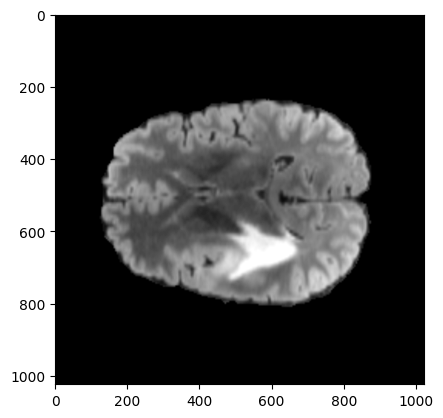

In [ ]:
sample = train[50]

# temp = 
plt.imshow(sample['image'][0,:,:].cpu(), cmap = "gray")


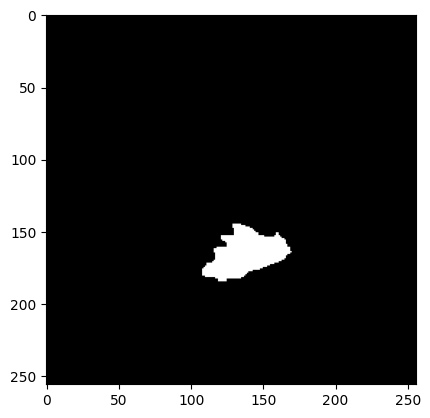

In [ ]:
plt.imshow(sample['mask'][0,:,:].cpu(), cmap = "gray")


(431, 581)


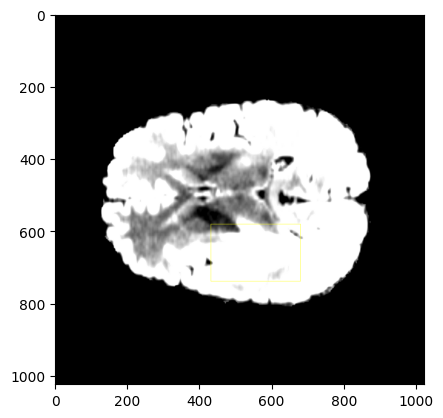

In [ ]:
x1, y1, x2, y2 = sample['box'].cpu()[0].numpy()

start = (x1, y1)
end = (x2, y2)

print(start)
colour = (255, 255, 0)
thickness = 1
im = np.array(sample['image'].cpu())[0,:,:]
im = np.stack((im, im, im), axis = -1 )
rectangle_img = cv2.rectangle(im, start, end, colour, thickness)
plt.imshow(rectangle_img, cmap="gray")


In [ ]:
train_loader = DataLoader(train, batch_size=2,
                        shuffle=True, num_workers=0)


In [ ]:
for i_batch, sample_batched in enumerate(train_loader):
    print(i_batch, sample_batched['image'].size(),
          sample_batched['mask'].size())
    if i_batch == 2: break

0 torch.Size([2, 3, 1024, 1024]) torch.Size([2, 1, 256, 256])
1 torch.Size([2, 3, 1024, 1024]) torch.Size([2, 1, 256, 256])
2 torch.Size([2, 3, 1024, 1024]) torch.Size([2, 1, 256, 256])


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## Model

In [ ]:
def dice_loss(y_true, y_pred):
    """
    implementation for generalized dice score loss
    GDL = 1 - (2 * sum(intersection)/(sum(pred)+sum(true)))
    """

    # y_pred = tf.round(y_pred)
    intersection = torch.sum(y_true * y_pred)
    pred_sum = torch.sum( y_pred)
    true_sum = torch.sum( y_true)
    smooth = torch.ones_like(intersection)*1e-5
    return 1-((2*intersection+smooth)/(pred_sum+true_sum+smooth))

In [ ]:
# import pickle

# def try_load_case(name, path):
#   if name in os.listdir(path):
#     data = pickle.load(os.path.join(path, name+".pkl"))
#     embedding, sparse_embeddings, dense_embeddings = data
#     return embedding, sparse_embeddings, dense_embeddings

#   embedding = sam_model.image_encoder(image)
#   box_np = [0,0,1024,1024]

#   # box_np = boxes.numpy()
#   # sam_trans = ResizeLongestSide(sam_model.image_encoder.img_size)
#   # box = sam_trans.apply_boxes(box_np, (gt2D.shape[-2], gt2D.shape[-1]))
#   box_torch = torch.as_tensor(box_np, dtype=torch.float, device=device)
#   # if len(box_torch.shape) == 2:
#   #     box_torch = box_torch[:, None, :] # (B, 1, 4)

#   # get prompt embeddings 
#   sparse_embeddings, dense_embeddings = sam_model.prompt_encoder(
#       points=None,
#       boxes=box_torch,
#       masks=None,
#   )

#   with open(os.path.join(path, name+".pkl"), "wb") as f:
#     pickle.dump(f, (embedding, sparse_embeddings, dense_embeddings))

#   return embedding, sparse_embeddings, dense_embeddings 

In [ ]:
# wandb.login(key="ceea57abce5a0d7ba2386c83228c1e4404c730f6")
# wandb.init(project = "SAM Finetune", 
#            save_code = True, group= 'Decoder_only', name = 'test', 
#            notes= 'fine tune sam decoder on brats 2021', resume = True, id = 'test_1')

In [ ]:
def train(**kwargs):
    model_save_path = kwargs['model_save_path']
    num_epochs = kwargs['num_epochs']
    best_loss = kwargs['best_loss']
    lr = kwargs['lr']
    weight_decay = kwargs['weight_decay']
    device = kwargs['device']
    train_dataloader = kwargs['train_dataloader']
    embedding_path = kwargs['embedding_path']
    
        
    # prepare SAM model
    model_type = 'vit_h'
    checkpoint = 'sam_vit_h_4b8939.pth'
    os.makedirs(model_save_path, exist_ok=True)
    sam_model = sam_model_registry[model_type](checkpoint=checkpoint).to(device)
    sam_model.train()
    # Set up the optimizer, hyperparameter tuning will improve performance here
    optimizer = torch.optim.Adam(sam_model.mask_decoder.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, verbose=True, factor=0.25,  patience=5)
    seg_loss = dice_loss #monai.losses.DiceCELoss(sigmoid=True, squared_pred=True, reduction='mean')



    for epoch in range(num_epochs):
        epoch_loss = 0
        # train
        for step, data in enumerate(tqdm(train_dataloader)):
            image, mask, box= data["image"], data["mask"], data["box"]


            with torch.no_grad(): 
              embedding = sam_model.image_encoder(image)
              box_np = box
              print(box_np.shape)
              box_torch = torch.as_tensor(box_np, dtype=torch.float, device=device)
              

              sparse_embeddings, dense_embeddings = sam_model.prompt_encoder(
                  points=None,
                  boxes=box_np,
                  masks=None,
              )

               
            # predicted masks 
            mask_predictions, _ = sam_model.mask_decoder(
              image_embeddings= embedding.to(device), # (B, 256, 64, 64)
              image_pe=sam_model.prompt_encoder.get_dense_pe(), # (1, 256, 64, 64)
              sparse_prompt_embeddings=sparse_embeddings, # (B, 2, 256)
              dense_prompt_embeddings=dense_embeddings, # (B, 256, 64, 64)
              multimask_output=False,
            )

            loss = seg_loss(mask_predictions, mask.to(device))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            scheduler.step(loss)
            epoch_loss += loss.item()

        epoch_loss /= step
        print(f'EPOCH: {epoch}, Loss: {epoch_loss}')
        # wandb.log({"epoch": epoch, "loss": loss})

        # save the latest model checkpoint
        # torch.save(sam_model.state_dict(), os.path.join(model_save_path, 'sam_model_'+str(epoch)+'.pth'))
        
        # save the best model
        if epoch_loss < best_loss:
            best_loss = epoch_loss
            torch.save(sam_model.state_dict(), os.path.join(model_save_path, 'sam_model_best.pth'))

In [ ]:
hprams = {
    "num_epochs": 100,
    "best_loss": 1e10,
    "model_save_path": "/content/model",
    "lr":1e-5,
    "weight_decay":0,
    "device": 'cuda',
    "embedding_path": "/scratch/guest190/kaggle_np/train_embedding/flair/",
    "train_dataloader": train_loader,
    }

In [ ]:
train(**hprams)

  0%|          | 0/33 [00:04<?, ?it/s]

torch.Size([2, 1, 4])


RuntimeError: ignored